# Modules

In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 6]
plt.style.use('ggplot')

In [3]:
from concurrent.futures import ProcessPoolExecutor, as_completed
from fastprogress import progress_bar

def parallel(func, job_list, n_jobs=14):
    with ProcessPoolExecutor(max_workers=n_jobs) as pool:
        futures = [pool.submit(func, job) for job in job_list]
        for f in progress_bar(as_completed(futures), total=len(job_list)):
            pass
    return [f.result() for f in futures]

In [4]:
import gc
from warnings import filterwarnings
filterwarnings("ignore")

In [5]:
import datetime as dt
def to_dt(x):
    return dt.datetime.fromtimestamp(int(x / 1000))

In [6]:
from multiprocessing import Pool
num_partitions = 100
num_cores = 12
def parallelize_dataframe(df, func):
    df_split = np.array_split(df, num_partitions)
    pool = Pool(num_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

# Sessions

In [7]:
sessions = pd.read_pickle('../../session.pkl')

In [11]:
sessions.sort_values(['system_time', 'user_id_hash'], inplace=True)

In [8]:
sessions.user_created_timestamp = sessions.user_created_timestamp.apply(to_dt)

In [10]:
sessions.drop(['week_start', 'device_id', 'user_days'], inplace=True, axis=1)

In [ ]:
region_remove = set([k for k, v in dict(sessions.region.value_counts()).items() if v <= 1000])
sessions.region = sessions.region.cat.add_categories(['unk'])
sessions.loc[sessions.region.isin(region_remove), ['region']] = 'unk'
sessions.region = sessions.region.cat.remove_unused_categories()

In [16]:
city_remove = set([k for k, v in dict(sessions.city.value_counts()).items() if v <= 1000])
sessions.city = sessions.city.cat.add_categories(['unk'])
sessions.loc[sessions.city.isin(city_remove), ['city']] = 'unk'
sessions.city = sessions.city.cat.remove_unused_categories()

In [19]:
locale_remove = set([k for k, v in dict(sessions.locale.value_counts()).items() if v <= 1000])
sessions.locale = sessions.locale.cat.add_categories(['unk'])
sessions.loc[sessions.locale.isin(locale_remove), ['locale']] = 'unk'
sessions.locale = sessions.locale.cat.remove_unused_categories()

In [21]:
sessions.drop(['start_timestamp'], inplace=True, axis=1)

In [23]:
sessions['system_date'] = sessions.system_time.dt.date

In [25]:
sessions['user_time'] = sessions.user_time.dt.hour

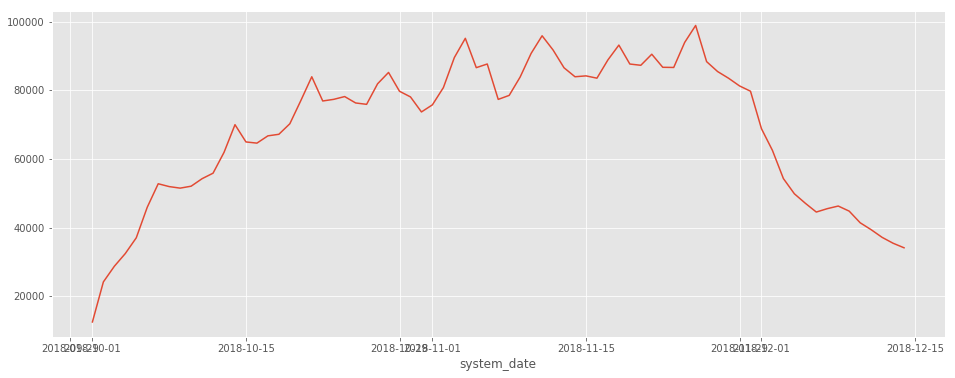

In [31]:
sessions.groupby(['system_date'])['session_id'].agg('nunique').plot()

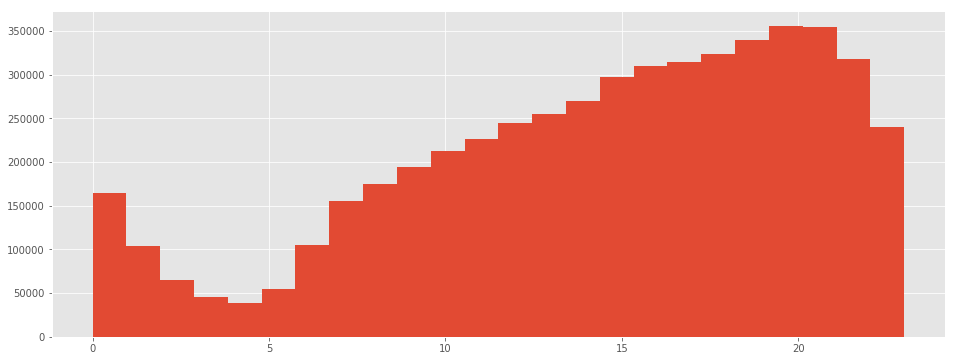

In [32]:
sessions.user_time.hist(bins=24)

In [18]:
sessions.head().T

,2555640,4768672,712447,1843043,1907788
session_id,4339488202460077611,7012480646309837595,2920311224184894615,8483277250870486701,8114762104527844914
start_timestamp,1538377204526,1538377208476,1538377262101,1538377290694,1538377317770
timezone,Australia/Sydney,Pacific/Auckland,Asia/Kolkata,America/Chicago,America/Los_Angeles
timezone_offset,36000000,46800000,19800000,-18000000,-25200000
previous_sessions_duration,0,0,1000637,0,2415582
user_created_timestamp,2018-10-01 07:00:04,2018-10-01 07:00:08,2018-10-01 06:44:08,2018-10-01 07:01:30,2018-10-01 06:18:23
is_user_first_session,True,True,False,True,False
country,AU,NZ,IN,US,US
region,qld,auk,tg,tx,ca
city,gold coast,auckland,hyderabad,houston,sacramento


In [33]:
t = sessions[['user_id_hash', 'user_created_timestamp']].drop_duplicates()

In [39]:
t = t.sort_values(['user_created_timestamp'])\
      .drop_duplicates(['user_id_hash'], keep='last').reset_index(drop=True)

In [42]:
t.to_pickle('../data/user_created.pkl')

In [8]:
sessions.sort_values(['system_time', 'user_id_hash'], inplace=True)
sessions.reset_index(inplace=True, drop=True)

In [9]:
time_df = sessions.system_time.dt.date.unique()
time_df = pd.DataFrame({'system_time': time_df})
# time_df.system_time = time_df.system_time.astype('datetime64[ns]')

In [10]:
sessions.drop(['anchor_date'], inplace=True, axis=1)

In [301]:
sessions = sessions[sessions.system_date >= dt.date(2018, 11, 24)]
sessions = sessions[sessions.system_date <= dt.date(2018, 11, 30)]

In [386]:
sessions = sessions[sessions.system_date >= dt.date(2018, 12, 8)]
sessions = sessions[sessions.system_date <= dt.date(2018, 12, 14)]

In [387]:
sessions['anchor_date'] = dt.date(2018, 11, 1)

In [389]:
time_df['map_date'] = dt.date(2018, 10, 1)
time_df.loc[time_df.system_time > dt.date(2018, 10, 13), ['map_date']] = \
    dt.date(2018, 11, 1)
# time_df.loc[time_df.system_time >= dt.date(2018, 12, 1), ['map_date']] = \
#     dt.date(2018, 12, 1)

In [12]:
time_df.columns = ['system_date', 'anchor_date']

In [13]:
time_df.groupby(['anchor_date']).system_date.count()

anchor_date
2018-10-01    13
2018-11-01    62
Name: system_date, dtype: int64

In [13]:
time_df.dtypes

system_date    object
anchor_date    object
dtype: object

In [17]:
sessions.dtypes

session_id                          category
timezone                            category
timezone_offset                     category
previous_sessions_duration             int64
user_created_timestamp        datetime64[ns]
is_user_first_session                   bool
country                             category
region                              category
city                                category
latitude                             float64
longitude                            float64
locale                              category
os_name                             category
session_index                          int64
user_id_hash                        category
user_time                              int64
system_time                   datetime64[ns]
system_date                           object
dtype: object

In [24]:
time_df.anchor_date = time_df.anchor_date.astype('datetime64[ns]')

In [26]:
# sessions.drop(['anchor_date'], inplace=True, axis=1)

In [18]:
sessions = sessions.merge(time_df, how='left')
sessions.anchor_date = sessions.anchor_date.astype('datetime64[ns]')

In [376]:
sessions.groupby(['anchor_date']).user_id_hash.count()

anchor_date
2018-11-01    418871
Name: user_id_hash, dtype: int64

In [390]:
def custom_aggregate(df, t='anchor_date'):
    grp_cols = [t, 'user_id_hash']
    grpby_obj = df.groupby(grp_cols)

    # number of sessions
    temp = grpby_obj.city.count().to_frame().reset_index().\
                rename(columns={'city': 'no_sessions'})

    # number of cities
    temp1 = grpby_obj.city.agg('nunique')\
                     .to_frame().reset_index()\
                     .rename(columns={'city': 'no_city'})

    # last city
    temp2 = grpby_obj.city.last().to_frame().reset_index()\
                     .rename(columns={'city': 'last_city'})
    
    # last country
    temp3 = grpby_obj.country.last().to_frame().reset_index()\
                     .rename(columns={'country': 'last_country'})

    # last region
    temp4 = grpby_obj.region.last().to_frame().reset_index()\
                     .rename(columns={'region': 'last_region'})

    # no of region
    temp5 = grpby_obj.region.agg('nunique')\
                     .to_frame().reset_index()\
                     .rename(columns={'region': 'region_count'})

    # last locale
    temp6 = grpby_obj.locale.last().to_frame().reset_index()\
                     .rename(columns={'locale': 'last_locale'})

    # agg session time
    temp7 = grpby_obj.previous_sessions_duration.sum()\
                      .to_frame().reset_index()\
                      .rename(columns={'previous_sessions_duration': 'total_session_time'})

    # mean session time
    temp8 = grpby_obj.previous_sessions_duration.mean().\
                to_frame().reset_index().\
                rename(columns={'previous_sessions_duration': 'mean_session_time'})

    # median session time
    temp9 = grpby_obj.previous_sessions_duration.median().\
                to_frame().reset_index().\
                rename(columns={'previous_sessions_duration': 'median_session_time'})

    # count session time
    temp10 = grpby_obj.previous_sessions_duration.count().\
                to_frame().reset_index().\
                rename(columns={'previous_sessions_duration': 'count_session_time'})

    # count unique session time
    temp11 = grpby_obj.session_id.agg('nunique').\
                to_frame().reset_index().\
                rename(columns={'session_id': 'ncount_session_time'})

    # mean user hour
    temp12 = grpby_obj.user_time.mean().\
                to_frame().reset_index().\
                rename(columns={'session_id': 'mean_user_time'})

    for i in range(1, 13):
        temp = temp.merge(locals()[f'temp{i}'], 
                          on=grp_cols)
    return temp

In [378]:
sessions.shape

(418871, 19)

In [22]:
sessions = sessions[sessions.anchor_date == dt.date(2018, 11, 1)]

In [304]:
sessions.shape

(611517, 19)

In [391]:
sessions.anchor_date = sessions.anchor_date.astype('datetime64[ns]')

In [392]:
sessions = custom_aggregate(sessions)

In [393]:
gc.collect()

364

In [86]:
sessions.to_pickle('../data/sessions.pkl')

In [385]:
sessions = pd.read_pickle('../data/sessions.pkl')

In [87]:
sessions_agg = result.copy(deep=True)
del result
sessions_agg.to_pickle('../data/sessions_agg.pkl')
gc.collect()

133574

In [88]:
del sessions
gc.collect()

996

# Events

In [89]:
events = pd.read_pickle('../../events.pkl')

In [90]:
events.drop(['week_start'], inplace=True, axis=1)

In [91]:
events.sort_values(['system_time', 'user_id_hash'], inplace=True)

In [92]:
{'ab': 97, 'message': 98, 'campaing': 99}

{'ab': 97, 'message': 98, 'campaing': 99}

In [93]:
events.reset_index(inplace=True, drop=True)

In [94]:
events.event = events.event.cat.add_categories([97, 98, 99])
events.loc[events.event_type == 'ab', 'event'] = 97
events.loc[events.event_type == 'message', 'event'] = 98
events.loc[events.event_type == 'campaing', 'event'] = 99
events.event = events.event.cat.remove_unused_categories()

In [95]:
drop_events = ['10', '51', '61', '62', '99', '0/', '1/', '32']
for e in drop_events:
    even = events[events.event != e]
events.drop(['event_type'], inplace=True, axis=1)
events.drop(['event_timestamp', 'session_id', 'system_date'], inplace=True, axis=1)
events.reset_index(inplace=True, drop=True)

In [97]:
events.head()

,event,event_value,user_id_hash,system_time
0,97,0.0,c9bad12f865142f1b3938c9ab8a3003a7882136a2b4a12...,2018-10-01 07:00:04
1,97,0.0,c9bad12f865142f1b3938c9ab8a3003a7882136a2b4a12...,2018-10-01 07:00:04
2,97,0.0,285863e47df26bf47664c93d45c35ee3b9cfc8e253da23...,2018-10-01 07:00:08
3,44,0.0,285863e47df26bf47664c93d45c35ee3b9cfc8e253da23...,2018-10-01 07:00:40
4,5,0.0,285863e47df26bf47664c93d45c35ee3b9cfc8e253da23...,2018-10-01 07:00:42


In [98]:
events[events.event == '8'].shape

(265034, 4)

In [36]:
def get_mode(x):
    try:
        return x.value_counts().index[0]
    except:
        return None

def custom_aggregate(df):

    grp_cols = ['anchor_date', 'event', 'user_id_hash']
    grpby_obj = df.groupby(grp_cols)
    
    temp = grpby_obj.event_value.count().to_frame().reset_index()\
                .rename(columns={'event_value': 'event_count'})
    temp1 = grpby_obj.event_value.sum().to_frame().reset_index()\
                .rename(columns={'event_value': 'event_sum'})
    temp2 = grpby_obj.event_value.mean().to_frame().reset_index()\
                .rename(columns={'event_value': 'event_mean'})
#     temp3 = grpby_obj.event_value.agg(lambda x: get_mode(x))\
#                                  .to_frame().reset_index()\
#                                  .rename(columns={'event_value': 'event_mode'})
    temp3 = grpby_obj.event_value.last()\
                                 .to_frame().reset_index()\
                                 .rename(columns={'event_value': 'event_last'})

    for i in range(1, 4):
        temp = temp.merge(locals()[f'temp{i}'], 
                          on=grp_cols)
    return temp

In [51]:
def wrapper_agg(wst):
    events_ss = events[events.anchor_date == wst].copy()
    return custom_aggregate(events_ss)

In [108]:
events['system_date'] = events.system_time.dt.date

In [28]:
events.drop(['anchor_date'], inplace=True, axis=1)

In [29]:
events.dtypes

event                 category
event_value            float64
user_id_hash          category
system_time     datetime64[ns]
system_date             object
dtype: object

In [30]:
time_df.dtypes

system_date    object
anchor_date    object
dtype: object

In [31]:
events = events.merge(time_df, how='left')

In [32]:
events.anchor_date = events.anchor_date.astype('datetime64[ns]')

In [32]:
events.groupby(['anchor_date']).event.count()

anchor_date
2018-10-01    12908430
2018-11-01    99038167
Name: event, dtype: int64

In [33]:
events = events[events.anchor_date == dt.date(2018, 11, 1)]

In [34]:
events.shape

(99038167, 6)

In [37]:
events = custom_aggregate(events)

In [53]:
result = parallel(wrapper_agg, events.anchor_date.unique())

In [54]:
result = pd.concat(result)

In [55]:
result.shape

(6346000, 7)

In [27]:
events = pd.read_pickle('../data/events.pkl')

In [56]:
events.to_pickle('../data/events.pkl')
events_agg = result.copy(deep=True)
del result
events_agg.to_pickle('../data/events_agg.pkl')
gc.collect()

1817

In [49]:
gc.collect()

3053

# Attributes

In [470]:
del sessions
gc.collect()

1273

In [471]:
attrib = pd.read_pickle('../data/atr.pkl')

MemoryError: 

In [39]:
attrib.sort_values(['system_date', 'user_id_hash'], inplace=True)
attrib.reset_index(inplace=True, drop=True)

In [ ]:
attrib = attrib[attrib.system_date >= dt.date(2018, 11, 24)]
attrib = attrib[attrib.system_date <= dt.date(2018, 11, 30)]

In [386]:
sessions = sessions[sessions.system_date >= dt.date(2018, 12, 8)]
sessions = sessions[sessions.system_date <= dt.date(2018, 12, 14)]

In [40]:
attrib.head()

,attribute,attribute_value,user_id_hash,system_date
0,0,0.0,0008ae1788be9473a11dd8efdc61010ad2a54ffe5e17ad...,2018-10-01
1,1,0.0,0008ae1788be9473a11dd8efdc61010ad2a54ffe5e17ad...,2018-10-01
2,3,0.0,0008ae1788be9473a11dd8efdc61010ad2a54ffe5e17ad...,2018-10-01
3,4,0.0,0008ae1788be9473a11dd8efdc61010ad2a54ffe5e17ad...,2018-10-01
4,5,1.0,0008ae1788be9473a11dd8efdc61010ad2a54ffe5e17ad...,2018-10-01


In [48]:
time_df = attrib.system_date.unique()
time_df = pd.DataFrame({'system_date': time_df})
time_df.system_date = time_df.system_date.astype('datetime64[ns]')
time_df['map_date'] = dt.date(2018, 10, 1)
time_df.loc[time_df.system_date >= dt.date(2018, 11, 1), ['map_date']] = \
    dt.date(2018, 11, 1)
time_df.loc[time_df.system_date >= dt.date(2018, 12, 1), ['map_date']] = \
    dt.date(2018, 12, 1)

In [44]:
attrib.system_date = attrib.system_date.astype('datetime64[ns]')

In [42]:
#attrib.drop(['anchor_date'], inplace=True, axis=1)

In [46]:
attrib.dtypes

attribute                category
attribute_value           float64
user_id_hash             category
system_date        datetime64[ns]
dtype: object

In [47]:
time_df.dtypes

system_date    datetime64[ns]
anchor_date            object
dtype: object

In [45]:
time_df.system_date = time_df.system_date.astype('datetime64[ns]')

In [48]:
attrib = attrib.merge(time_df, how='left')

In [49]:
attrib.head()

,attribute,attribute_value,user_id_hash,system_date,anchor_date
0,0,0.0,0008ae1788be9473a11dd8efdc61010ad2a54ffe5e17ad...,2018-10-01,2018-10-01
1,1,0.0,0008ae1788be9473a11dd8efdc61010ad2a54ffe5e17ad...,2018-10-01,2018-10-01
2,3,0.0,0008ae1788be9473a11dd8efdc61010ad2a54ffe5e17ad...,2018-10-01,2018-10-01
3,4,0.0,0008ae1788be9473a11dd8efdc61010ad2a54ffe5e17ad...,2018-10-01,2018-10-01
4,5,1.0,0008ae1788be9473a11dd8efdc61010ad2a54ffe5e17ad...,2018-10-01,2018-10-01


In [53]:
attrib.groupby(['anchor_date']).attribute.count()

anchor_date
2018-11-01    122802233
Name: attribute, dtype: int64

In [54]:
def weekly_aggregate(df):

    grp_cols = ['anchor_date', 'attribute', 'user_id_hash']
    grpby_obj = df.groupby(grp_cols)
    
    temp = grpby_obj.attribute_value.count().to_frame().reset_index()\
                .rename(columns={'attribute_value': 'atr_count'})
    temp1 = grpby_obj.attribute_value.mean().to_frame().reset_index()\
                .rename(columns={'attribute_value': 'atr_mean'})
    temp2 = grpby_obj.attribute_value.last().to_frame().reset_index()\
                .rename(columns={'attribute_value': 'atr_last'})
    temp3 = grpby_obj.attribute_value.max().to_frame().reset_index()\
                .rename(columns={'attribute_value': 'atr_max'})

    for i in range(1, 4):
        temp = temp.merge(locals()[f'temp{i}'], 
                          on=grp_cols)
    return temp

In [52]:
attrib = attrib[attrib.anchor_date == dt.date(2018, 11, 1)]

In [55]:
attrib = weekly_aggregate(attrib)

In [75]:
def wrapper_agg(wst):
    attrib_ss = attrib[attrib.anchor_date == wst].copy()
    return weekly_aggregate(attrib_ss)

In [60]:
attrib_sub = attrib.sample(n=1000).copy(deep=True)

In [76]:
result = parallel(wrapper_agg, attrib_sub.anchor_date.unique())

In [77]:
result = pd.concat(result)

In [78]:
result.shape

(24048310, 7)

In [79]:
attrib_agg = result.copy(deep=True)
del result
attrib_agg.to_pickle('../data/attrib_agg.pkl')
gc.collect()

818

# Getting Sessions Ready

In [56]:
# sessions = pd.read_pickle('../data/sessions_agg.pkl')
# events = pd.read_pickle('../data/events_agg.pkl')
user_date = pd.read_pickle('../data/user_created.pkl')

In [57]:
sessions = sessions.merge(user_date, on=['user_id_hash'], how='left')

In [58]:
from dateutil.relativedelta import relativedelta

In [59]:
sessions.anchor_date = sessions.anchor_date.astype('datetime64[ns]')

In [60]:
sessions.shape

(529655, 16)

In [61]:
sessions['user_age'] = sessions.anchor_date\
                        .apply(lambda x: x + relativedelta(months=+1)).dt.date - \
                            sessions.user_created_timestamp.dt.date

In [62]:
sessions['user_age'] = sessions.user_age.apply(lambda x: x.days)

In [63]:
sessions.head()

,anchor_date,user_id_hash,no_sessions,no_city,last_city,last_country,last_region,region_count,last_locale,total_session_time,mean_session_time,median_session_time,count_session_time,ncount_session_time,user_time,user_created_timestamp,user_age
0,2018-11-01,00000db35682058bb7916cb90f85709f54c1a0f7a3b6de...,23,1,brisbane,AU,qld,1,en-AU_AU,176961572,7.693981e+06,4759962.0,23,23,15.782609,2018-11-10 07:00:34,21
1,2018-11-01,000059859ec188af6035870faf885c3038cedda05b3a54...,10,1,unk,US,ca,1,en_US,45243043,4.524304e+06,4971428.0,10,10,14.000000,2018-11-22 19:10:12,9
2,2018-11-01,00006ad44c0d33a2a526caf75514643639b7b7070dfffd...,7,1,bandung,ID,jb,1,en_US,28731851,4.104550e+06,4705231.0,7,7,12.571429,2018-10-18 03:48:45,44
3,2018-11-01,000081a7d841b0f953bdba6c185fd5cc335fd6015a30c3...,3,1,chesapeake,US,va,1,en_US,2740502,9.135007e+05,1006370.0,3,3,17.333333,2018-11-22 20:34:45,9
4,2018-11-01,0000a464ad921c3288e73a3a788b5f113cabf84251a74b...,2,1,fresno,US,ca,1,en-US_US,1073964,5.369820e+05,536982.0,2,2,19.500000,2018-11-22 06:13:36,9


In [64]:
sessions.drop(['user_created_timestamp'], inplace=True, axis=1)

In [65]:
sessions.user_id_hash = sessions.user_id_hash.astype('category')
sessions.last_city = sessions.last_city.astype('category')
sessions.last_country = sessions.last_country.astype('category')
sessions.last_region = sessions.last_region.astype('category')
sessions.last_locale = sessions.last_locale.astype('category')

In [66]:
purchase = events[events.event == '8'].copy(deep=True)
purchase.reset_index(inplace=True, drop=True)

In [67]:
purchase.drop(['event', 'event_mean'], inplace=True, axis=1)

In [68]:
purchase.columns = ['anchor_date', 'user_id_hash', 'no_of_buys',
                    'sum_buys', 'popular_buy']

In [69]:
purchase.head()

,anchor_date,user_id_hash,no_of_buys,sum_buys,popular_buy
0,2018-11-01,00000db35682058bb7916cb90f85709f54c1a0f7a3b6de...,8,23.044,3.493
1,2018-11-01,000059859ec188af6035870faf885c3038cedda05b3a54...,1,1.393,1.393
2,2018-11-01,000d99c8e82878915b33ffe27ac3585ce9fb7cd4b82ace...,7,9.751,1.393
3,2018-11-01,00124c21b3ec87a2f17f884c5eee25462b67d489ebad09...,3,6.279,1.393
4,2018-11-01,0012e392350f0f6408b8b1a03bc5ee292e29dc735ee24d...,2,2.786,1.393


In [70]:
sessions.shape

(529655, 16)

In [74]:
purchase.anchor_date = purchase.anchor_date.astype('datetime64[ns]')

In [75]:
sessions = sessions.merge(purchase, on=['anchor_date', 'user_id_hash'], how='left')

In [76]:
sessions.shape

(529655, 19)

In [77]:
events.shape

(4797842, 7)

In [78]:
events = events[events.event != '8']

In [79]:
events.set_index(['anchor_date', 'user_id_hash', 'event'], inplace=True)

In [80]:
events = events.unstack()

In [81]:
events.columns = [i + str(j) for  i, j  in zip (events.columns.get_level_values(0),
                                                events.columns.get_level_values(1))]

In [82]:
for c in events.columns[events.isna().sum() > 0].values:
    events[c].fillna(-99, inplace=True)

In [83]:
events.reset_index(inplace=True)

In [84]:
sessions = sessions.merge(events, on=['anchor_date', 'user_id_hash'], how='left')

In [85]:
sessions.shape

(529655, 175)

In [8]:
sessions = pd.read_pickle('../../df.pkl')
attrib = pd.read_pickle('../data/attrib_agg.pkl')

In [9]:
attrib.shape

(24048310, 7)

In [86]:
attrib.dtypes

anchor_date       object
attribute       category
user_id_hash    category
atr_count          int64
atr_mean         float64
atr_last         float64
atr_max          float64
dtype: object

In [88]:
attrib.anchor_date = attrib.anchor_date.astype('datetime64[ns]')

In [89]:
attrib.head()

,anchor_date,attribute,user_id_hash,atr_count,atr_mean,atr_last,atr_max
0,2018-11-01,0,00000db35682058bb7916cb90f85709f54c1a0f7a3b6de...,23,0.173913,1.0,1.0
1,2018-11-01,0,000059859ec188af6035870faf885c3038cedda05b3a54...,11,0.000000,0.0,0.0
2,2018-11-01,0,00006ad44c0d33a2a526caf75514643639b7b7070dfffd...,8,0.000000,0.0,0.0
3,2018-11-01,0,000081a7d841b0f953bdba6c185fd5cc335fd6015a30c3...,4,0.000000,0.0,0.0
4,2018-11-01,0,0000a464ad921c3288e73a3a788b5f113cabf84251a74b...,2,0.000000,0.0,0.0


In [90]:
attrib.set_index(['anchor_date', 'user_id_hash', 'attribute'], inplace=True)

In [91]:
attrib = attrib.unstack()

In [92]:
attrib.columns = [i + str(j) for  i, j  in zip (attrib.columns.get_level_values(0),
                                                attrib.columns.get_level_values(1))]

In [93]:
for c in attrib.columns[attrib.isna().sum() > 0].values:
    attrib[c].fillna(-99, inplace=True)

In [94]:
attrib.reset_index(inplace=True)

In [95]:
sessions = sessions.merge(attrib, on=['anchor_date', 'user_id_hash'], how='left')

In [96]:
sessions.shape

(529655, 283)

In [97]:
del events
gc.collect()

2722

In [98]:
del attrib
gc.collect()

7

# Creating y1 & y2

In [89]:
events = pd.read_pickle('../../events.pkl')

In [90]:
purchase = events[events.event == '8'].copy(deep=True)
purchase.reset_index(inplace=True, drop=True)

In [91]:
purchase = purchase[purchase.system_time >= dt.datetime(2018, 12, 1)]

In [92]:
y1_uidh = purchase[purchase.system_time < dt.datetime(2018, 12, 8)].user_id_hash.unique()

In [93]:
len(y1_uidh)

4729

In [94]:
y2_uidh = purchase.user_id_hash.unique()

In [95]:
len(y2_uidh)

6126

In [96]:
sessions['y1'] = sessions.user_id_hash.isin(y1_uidh)
sessions['y2'] = sessions.user_id_hash.isin(y2_uidh)

In [97]:
del events
gc.collect()

268

# Preprocessing

In [99]:
sessions.anchor_date.unique()

array(['2018-11-01T00:00:00.000000000'], dtype='datetime64[ns]')

In [74]:
sessions = sessions[sessions.anchor_date == dt.datetime(2018, 11, 1)]

In [101]:
df = sessions

In [102]:
df['y1'].fillna(0, inplace=True)
df['y2'].fillna(0, inplace=True)
df['no_of_buys'].fillna(0, inplace=True)
df['sum_buys'].fillna(0, inplace=True)
df['popular_buy'].fillna(0, inplace=True)

In [103]:
for c in ['no_sessions', 'no_city', 'region_count', 'total_session_time',
          'mean_session_time', 'median_session_time', 'count_session_time',
          'ncount_session_time', 'user_time', 'user_age']:
    df[c].fillna(0, inplace=True)

In [104]:
for c in ['last_city', 'last_country', 'last_region', 'last_locale']:
    df[c] = df[c].cat.add_categories(-99)
    df[c].fillna(-99, inplace=True)

In [105]:
for c in [i for i in df.columns if i.startswith('event')]:
    df[c].fillna(-99, inplace=True)

In [106]:
t = df.isna().sum()

In [107]:
t.sum()

0

In [128]:
df.last_city = df.last_city.cat.codes
df.last_country = df.last_country.cat.codes
df.last_region = df.last_region.cat.codes
df.last_locale = df.last_locale.cat.codes

In [106]:
df['y1'] = df['y1'].astype(np.int)
df['y2'] = df['y2'].astype(np.int)

In [22]:
df.fillna(-99, inplace=True)

In [108]:
df.columns.values

array(['anchor_date', 'user_id_hash', 'no_sessions', 'no_city',
       'last_city', 'last_country', 'last_region', 'region_count',
       'last_locale', 'total_session_time', 'mean_session_time',
       'median_session_time', 'count_session_time', 'ncount_session_time',
       'user_time', 'user_age', 'no_of_buys', 'sum_buys', 'popular_buy',
       'event_count0', 'event_count0/', 'event_count1', 'event_count1/',
       'event_count10', 'event_count11', 'event_count14', 'event_count3',
       'event_count4', 'event_count40', 'event_count41', 'event_count42',
       'event_count43', 'event_count44', 'event_count45', 'event_count47',
       'event_count48', 'event_count49', 'event_count5', 'event_count50',
       'event_count51', 'event_count52', 'event_count54', 'event_count55',
       'event_count56', 'event_count57', 'event_count58', 'event_count59',
       'event_count6', 'event_count60', 'event_count61', 'event_count62',
       'event_count63', 'event_count64', 'event_count7', 'even

In [109]:
df.to_pickle('../data/test2mnths')

In [108]:
df.to_pickle('../data/train2mnths')

In [111]:
del df
del sessions
del purchase
del attrib
gc.collect()

172

In [293]:
train = pd.read_pickle('../data/train2mnths')
test = pd.read_pickle('../data/test2mnths')

In [476]:
gc.collect()

668

In [475]:
del X_train, X_test, y1, y2, 

In [477]:
train.to_pickle('../data/trainv2')
test.to_pickle('../data/testv2')

MemoryError: 

In [394]:
sessions = sessions[['user_id_hash', 'no_sessions', 'total_session_time', 'mean_session_time',
                     'median_session_time', 'user_time']]

In [395]:
sessions.columns = ['user_id_hash', 'no_sessions_wk', 'total_session_time_wk',
                    'mean_session_time_wk', 'median_session_time_wk',
                    'user_time_wk']

In [396]:
sessions.head()

,user_id_hash,no_sessions_wk,total_session_time_wk,mean_session_time_wk,median_session_time_wk,user_time_wk
0,00000db35682058bb7916cb90f85709f54c1a0f7a3b6de...,1,20109700,2.010970e+07,20109700.0,21.00
1,0004254c12f732e958e157c5e507347944e7ae2b0d9abc...,1,45213917,4.521392e+07,45213917.0,18.00
2,000640d9f785d21ded61bdff159144b25dea23300ae1b8...,1,162513580,1.625136e+08,162513580.0,20.00
3,00073f51e4e86c623799a82241256f7c1898c589850d5a...,4,187610585,4.690265e+07,46616772.0,13.75
4,0007e356e960e1a802454c83e1a6cea122cbd32d6382df...,1,2692708,2.692708e+06,2692708.0,19.00


In [397]:
test = test.merge(sessions, on=['user_id_hash'], how='left')

In [313]:
train = train.merge(sessions, on=['user_id_hash'], how='left')

In [398]:
for c in ['no_sessions_wk', 'total_session_time_wk', 'mean_session_time_wk',
          'median_session_time_wk', 'user_time_wk']:
    try:
        test[c] = test[c].cat.add_categories(0)
        test[c].fillna(0, inplace=True)
    except:
        test[c].fillna(0, inplace=True)

In [319]:
for c in ['no_sessions_wk', 'total_session_time_wk', 'mean_session_time_wk',
          'median_session_time_wk', 'user_time_wk']:
    try:
        train[c] = train[c].cat.add_categories(0)
        train[c].fillna(0, inplace=True)
    except:
        train[c].fillna(0, inplace=True)

In [399]:
test.isna().sum().sum()

0

In [322]:
train.isna().sum().sum()

0

In [321]:
from sklearn.preprocessing import LabelEncoder

In [335]:
for c in ['last_city', 'last_country', 'last_region', 'last_locale']:
    le = LabelEncoder()
    le.fit(list(set(list(train[c].values) + list(test[c].values))))
    train[c] = le.transform(list(train[c].values))
    test[c] = le.transform(list(test[c].values))

In [400]:
feature_cols = ['no_sessions', 'no_city',
                'last_city', 'last_country', 'last_region', 'last_locale',
                'total_session_time', 'region_count',
                'mean_session_time', 'median_session_time', 'count_session_time',
                'ncount_session_time', 'user_age', 'no_of_buys', 'sum_buys',
                'popular_buy',]
feature_cols += ['no_sessions_wk', 'total_session_time_wk',
                    'mean_session_time_wk', 'median_session_time_wk',
                    'user_time_wk']

In [401]:
feature_cols += [f for f in train.columns if f.startswith('event')]

In [402]:
feature_cols += [f for f in train.columns if f.startswith('atr')]

In [352]:
feature_cols += [f for f in train.columns if f.startswith('atr') and f.endswith('13')]

In [353]:
feature_cols += [f for f in train.columns if f.startswith('atr') and f.endswith('14')]

In [28]:
df.to_pickle('../data/df.pkl')

In [10]:
df = pd.read_pickle('../data/df.pkl')

# modelling

In [403]:
def print_feature_importance(model, feature_cols):
    feature_importance = dict(zip(feature_cols, model.feature_importances_))
    for name, importance in sorted(feature_importance.items(),
                                   key=lambda x: x[1], reverse=True):
        print(f"{name:<30}: {importance:>6.2%}")

In [404]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

In [405]:
from sklearn.model_selection import train_test_split

In [429]:
feature_cols = list(set([
'user_age', 'no_sessions_wk', 'last_locale', 'event_count0', 'user_time_wk', 'last_country', 'event_sum7', 'atr_mean20', 'last_region', 'last_city', 'atr_mean16', 'event_count45', 'event_mean5', 'atr_last1', 'atr_last5', 'no_of_buys', 'atr_mean19', 'event_mean7', 'atr_mean18', 'atr_mean1', 'atr_mean7', 'atr_last19', 'atr_last20', 'atr_mean8', 'atr_mean13', 'median_session_time', 'atr_mean4', 'atr_mean75', 'atr_max1', 'sum_buys', 'total_session_time_wk', 'event_count14', 'event_last7', 'atr_mean5', 'atr_mean15', 'atr_mean66', 'total_session_time', 'atr_max18', 'atr_mean6', 'atr_last7', 'event_count98', 'atr_count0', 'atr_last67', 'event_count1', 'popular_buy', 'atr_count67', 'atr_mean67', 'atr_mean14', 'event_count42', 'atr_mean21', 'no_city', 'mean_session_time', 'event_count7', 'event_count97', 'atr_mean0', 'atr_max13', 'atr_max15', 'atr_max16', 'mean_session_time_wk', 'median_session_time_wk', 'event_count5', 'atr_last16', 'atr_max19', 'no_sessions', 'event_count41', 'atr_last13', 'atr_mean3', 'atr_mean17', 'atr_last8', 'atr_max9', 'event_count4', 'atr_max8', 'atr_max66', 'event_sum11', 'atr_max7', 'atr_mean9', 'region_count', 'atr_count96', 'event_count6', 'event_last5', 'atr_last15', 'event_count40', 'atr_max75', 'atr_last66', 'event_count3', 'event_mean11', 'atr_count78', 'atr_last14', 'atr_max3', 'event_count44', 'event_sum5', 'atr_count66', 'atr_last3', 'atr_last6', 'atr_last18', 'atr_last75', 'atr_max5', 'atr_max6', 'event_count11', 'atr_count7', 'atr_last4', 'atr_last9', 'atr_max4', 'atr_max0', 'atr_max14', 'atr_max20', 'user_age', 'no_sessions_wk', 'last_country', 'atr_mean20', 'event_count0', 'last_locale', 'user_time_wk', 'last_region', 'last_city', 'event_sum7', 'event_mean7', 'atr_mean16', 'event_mean5', 'event_count1', 'event_count45', 'atr_last1', 'median_session_time', 'atr_mean1', 'atr_last7', 'no_of_buys', 'atr_mean19', 'event_count14', 'atr_mean7', 'total_session_time', 'atr_mean66', 'atr_mean18', 'atr_last5', 'total_session_time_wk', 'atr_mean8', 'atr_count67', 'atr_mean0', 'atr_mean13', 'atr_mean21', 'event_last7', 'atr_max1', 'atr_mean6', 'atr_last19', 'popular_buy', 'atr_mean17', 'atr_mean67', 'atr_mean15', 'atr_last20', 'atr_mean4', 'atr_mean75', 'event_count97', 'event_count42', 'median_session_time_wk', 'atr_mean5', 'mean_session_time', 'event_last5', 'no_city', 'atr_max18', 'mean_session_time_wk', 'atr_mean14', 'atr_max13', 'event_count98', 'sum_buys', 'atr_count7', 'region_count', 'atr_mean3', 'atr_last15', 'atr_mean9', 'atr_last13', 'atr_last67', 'event_count41', 'atr_max16', 'no_sessions', 'atr_last8', 'atr_last18', 'atr_last16', 'atr_max15', 'atr_max19', 'event_count7', 'event_count3', 'event_count5', 'atr_count0', 'event_count44', 'event_count6', 'atr_max7', 'event_count40', 'atr_count96', 'atr_max6', 'event_count4', 'atr_last6', 'atr_last9', 'atr_last66', 'atr_max5', 'atr_max8', 'atr_max66', 'event_sum5', 'atr_mean11', 'atr_max4', 'atr_max9', 'event_sum11', 'atr_last75', 'atr_max75', 'event_count9', 'atr_count5', 'atr_last4', 'atr_count78', 'atr_last14', 'atr_max3', 'atr_count66']))

In [430]:
# train = np.hstack((df[feature_cols].values, pd.get_dummies(df['last_country'])))

X_train, X_test, y_train, y_test = train_test_split(train[feature_cols].values,
                                                    train[['y1']],
                                                    test_size=0.1)

In [431]:
eval_set = [(X_train , y_train), (X_test, y_test)]

In [432]:
y_train.shape

(556982, 1)

In [433]:
y_train.sum()

y1    4268
dtype: int64

In [434]:
(252105 - 3301) / 3301

75.37231142078159

In [435]:
params = {
    'max_depth': 8,
    'n_jobs': -1,
    'learning_rate': 0.12,
    'n_estimators': 200,
    'min_child_weight': 10
}

In [436]:
xg_model1 = XGBClassifier(**params)

In [437]:
xg_model1.fit(X_train, y_train, eval_metric='auc',
              eval_set=eval_set, verbose=True,
              early_stopping_rounds=5)

[0]	validation_0-auc:0.942531	validation_1-auc:0.94038
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.946463	validation_1-auc:0.941409
[2]	validation_0-auc:0.95785	validation_1-auc:0.950019
[3]	validation_0-auc:0.958384	validation_1-auc:0.950253
[4]	validation_0-auc:0.958739	validation_1-auc:0.950333
[5]	validation_0-auc:0.959886	validation_1-auc:0.950246
[6]	validation_0-auc:0.960051	validation_1-auc:0.950253
[7]	validation_0-auc:0.96021	validation_1-auc:0.950191
[8]	validation_0-auc:0.960387	validation_1-auc:0.950349
[9]	validation_0-auc:0.960541	validation_1-auc:0.95039
[10]	validation_0-auc:0.960742	validation_1-auc:0.950464
[11]	validation_0-auc:0.962672	validation_1-auc:0.953547
[12]	validation_0-auc:0.962963	validation_1-auc:0.95403
[13]	validation_0-auc:0.974493	validation_1-auc:0.967068
[14]	validation_0-auc:0.974946	validation_1-auc:0.967303
[15]

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.12, max_delta_step=0,
       max_depth=8, min_child_weight=10, missing=None, n_estimators=200,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [438]:
# print_feature_importance(xg_model1, feature_cols)

In [439]:
# train = np.hstack((df[feature_cols].values, pd.get_dummies(df['last_country'])))

X_train, X_test, y_train, y_test = train_test_split(train[feature_cols].values,
                                                    train[['y2']],
                                                    test_size=0.1)

In [440]:
eval_set = [(X_train , y_train), (X_test, y_test)]

In [441]:
xg_model2 = XGBClassifier(**params)

In [442]:
xg_model2.fit(X_train, y_train, eval_metric='auc',
              eval_set=eval_set, verbose=True,
              early_stopping_rounds=5)

[0]	validation_0-auc:0.943118	validation_1-auc:0.946956
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.949301	validation_1-auc:0.953128
[2]	validation_0-auc:0.949836	validation_1-auc:0.953359
[3]	validation_0-auc:0.950027	validation_1-auc:0.953412
[4]	validation_0-auc:0.950095	validation_1-auc:0.953481
[5]	validation_0-auc:0.964368	validation_1-auc:0.965731
[6]	validation_0-auc:0.964512	validation_1-auc:0.965821
[7]	validation_0-auc:0.965984	validation_1-auc:0.967711
[8]	validation_0-auc:0.966463	validation_1-auc:0.96811
[9]	validation_0-auc:0.966799	validation_1-auc:0.968218
[10]	validation_0-auc:0.969249	validation_1-auc:0.969612
[11]	validation_0-auc:0.969649	validation_1-auc:0.969779
[12]	validation_0-auc:0.97011	validation_1-auc:0.969828
[13]	validation_0-auc:0.970439	validation_1-auc:0.969941
[14]	validation_0-auc:0.970692	validation_1-auc:0.970016
[

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.12, max_delta_step=0,
       max_depth=8, min_child_weight=10, missing=None, n_estimators=200,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [443]:
# print_feature_importance(xg_model2, feature_cols)

In [444]:
import pickle

In [445]:
pickle.dump(xg_model1, open('xg_2mnths1.dat', 'wb'))
pickle.dump(xg_model2, open('xg_2mnths2.dat', 'wb'))

In [446]:
gc.collect()

67

# Prediction

In [447]:
y1 = xg_model1.predict_proba(test[feature_cols].values)

In [448]:
y2 = xg_model2.predict_proba(test[feature_cols].values)

In [449]:
test['y1'] = y1[:,1]
test['y2'] = y2[:,1]

In [450]:
submission = test[['user_id_hash', 'y1', 'y2']]

In [451]:
submission.head()

,user_id_hash,y1,y2
0,00000db35682058bb7916cb90f85709f54c1a0f7a3b6de...,0.091478,0.177593
1,000059859ec188af6035870faf885c3038cedda05b3a54...,0.000671,0.057789
2,00006ad44c0d33a2a526caf75514643639b7b7070dfffd...,0.000489,0.055573
3,000081a7d841b0f953bdba6c185fd5cc335fd6015a30c3...,0.000487,0.055573
4,0000a464ad921c3288e73a3a788b5f113cabf84251a74b...,0.000487,0.055573


In [452]:
template = pd.read_csv('../../sample_submission_2.csv')

In [453]:
req_uids = set(template.user_id_hash)

In [454]:
len(req_uids)

312568

In [455]:
submission.user_id_hash.unique().shape

(529655,)

In [456]:
submission.user_id_hash.isin(req_uids).sum()

266924

In [457]:
submission = submission[submission.user_id_hash.isin(req_uids)]

In [458]:
submission.shape

(266924, 3)

In [459]:
left_out = list(set(template.user_id_hash.unique()) - set(submission.user_id_hash.unique()))

In [460]:
len(left_out)

45644

In [461]:
temp = pd.DataFrame(data={'user_id_hash': left_out,
                          'user_purchase_binary_7_days': np.zeros(len(left_out)),
                          'user_purchase_binary_14_days': np.zeros(len(left_out))})

In [462]:
temp.columns

Index(['user_id_hash', 'user_purchase_binary_7_days',
       'user_purchase_binary_14_days'],
      dtype='object')

In [463]:
submission.columns = temp.columns

In [464]:
submission = pd.concat([submission, temp])

In [465]:
submission.shape

(312568, 3)

In [466]:
submission.user_id_hash.unique().shape

(312568,)

In [467]:
submission.head()

,user_id_hash,user_purchase_binary_7_days,user_purchase_binary_14_days
0,00000db35682058bb7916cb90f85709f54c1a0f7a3b6de...,0.091478,0.177593
1,000059859ec188af6035870faf885c3038cedda05b3a54...,0.000671,0.057789
3,000081a7d841b0f953bdba6c185fd5cc335fd6015a30c3...,0.000487,0.055573
5,0000bc4e8bfc829d327fa69bdc426dd8a789c52550ed87...,0.000550,0.055573
6,0000c5de50d243cc39f6ac4268d7511705585ca3f2a20f...,0.000820,0.057260


In [468]:
submission.to_csv('../final2_sub.csv', index=False, float_format='%.2f')